## CDCS_seg_comp

This notebook retrieves melt pool images taken with a scanning electron microscope and compares the widths and lengths measured for these melt pools using the chan-vese segmentation algorithm to measurements of the optical images of the melt pools.

In [1]:
import pandas as py
import lxml.etree as et
from cdcs import CDCS
from urllib import request
from skimage import io

### 1. Retrieving melt pool images from ambench.nist.gov
- more detailed explanations for this process are written in the CDCS_MP notebook
- retriving scanning electron microscope images of melt pools taken as part of the grain size (GS) AM-Bench challenge

In [2]:
keyword='GS'
curator = CDCS('https://ambench.nist.gov/', username='') #accessing anonymously
df2=curator.query(template='AM-Bench-2018',keyword=keyword) #searching for results with 'GS'
df2

,id,template,workspace,user_id,title,xml_content,creation_date,last_modification_date,last_change_date,template_title
0,5fb6e80375853f004117ee6a,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR10-GS.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:47:47.936000Z,2020-11-19T21:47:47.936000Z,2020-11-19T21:51:27.447000Z,AM-Bench-2018
1,5fb6e72475853f003a17eb53,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR5-GS.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:44:04.965000Z,2020-11-19T21:44:04.965000Z,2020-11-19T21:51:31.807000Z,AM-Bench-2018
2,5fb6e70775853f003917eb9f,5fb54ec775853f003743b46f,5fb54c4975853f001635431e,3,AMB2018-02-AMMT-625-TR3-GS.xml,"<AMBench2018LB xmlns:xsi=""http://www.w3.org/2...",2020-11-19T21:43:35.988000Z,2020-11-19T21:43:35.988000Z,2020-11-19T21:51:32.141000Z,AM-Bench-2018


#### xml_url_find:
Parameters:
- XML file for one of the ambench.nist.gov datasets in string format
- search phrase contained in the file name
- file type

Returns:
- a list containing (0) name of a file, (1) the download url for the file, (2) laser track number, (3) case 

In [3]:
def xml_url_find(xml,searchphrase,mtype):
    root=et.fromstring(xml)
    track=root.find('.//TrackNumber')
    for element in root.iter('downloadURL'):
        u=request.urlopen(element.text)
        if searchphrase in u.info().get_filename() and mtype in u.info().get_content_type():
            return [u.info().get_filename(),element.text,track.text]

In [4]:
#getting SEM MP images
searchphrase='AMMT' #returns a list of scikit images
mtype='image/png'
filename2=[]
result2=[]
trace2=[]
for index in df2.index:
    res=xml_url_find(df2.iloc[index]['xml_content'],searchphrase,mtype)
    name=res[0]
    url=res[1]
    track=res[2]
    if url==None:
        continue
    else:
        filename2.append(name)
        result2.append(io.imread(url)) #reading in the urls using scikit
        trace2.append(int(track))

### 2. Image visualization and analysis
- uses the chan vese segmentation algorithm to isolate the melt pool
- converts needed images to black and white
- compares measurements from the SEM image analysis to measurements of the optical melt pool images contained in 'MP_measurements.csv' (calculated in CDCS_MP.ipynb)

In [5]:
import skimage
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure

#### draw_box_sem
This method (1) crops the melt pool images (to reduce runtime), (2) creates an elevation map of the image, (3) applies the Chan-Vese segmentation algorithm to the elevation map, (4) removes smaller regions (eliminates background noise), (5) returns information about the remaining region

Parameters:
- image to be analyzed

Returns:
- list of RegionProperties related to the melt pool region

In [7]:
def draw_box_sem(image):
    clipim=image[250:,:]
    elevation_map=filters.sobel(clipim)
    blurredim=filters.gaussian(elevation_map, sigma=9)
    segments=segmentation.morphological_chan_vese(blurredim,1)
    mask=np.array(segments, dtype='bool')
    isolateim=morphology.remove_small_objects(mask,100000) #Adjust the second parameter as needed to clear the image of 
    #unneeded objects
    labels=measure.label(isolateim)
    object_features=skimage.measure.regionprops(labels)
    return object_features

In [8]:
from skimage import color
depths2=[]
widths2=[]
for im in result2:
    if im.ndim>2: #checks the dimensions of the image - if 3, the image is in color, and must be converted to grayscale
        im=color.rgb2gray(im)
    objf=draw_box_sem(im)
    minr,minc,maxr,maxc=objf[0].bbox
    widths2.append(maxc-minc)
    depths2.append(maxr-minr)

<ipython-input-8-af7f92e1736a>:6: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im=color.rgb2gray(im)


In [9]:
dat2={'width (SEM)':widths2,'depth (SEM)':depths2}

In [10]:
dfgs=py.DataFrame(dat2)

In [11]:
dfgs['width (SEM)']=dfgs['width (SEM)']*10/641 #convert to microns
dfgs['depth (SEM)']=dfgs['depth (SEM)']*10/641

In [12]:
dfgs['track']=trace2 #adding track numbers
dfgs=dfgs.sort_values(by='track',ignore_index=True) #sort by track
dfgs=dfgs.set_index(dfgs['track'])

In [13]:
dfgs

,width (SEM),depth (SEM),track
track,,,
3,129.921997,36.333853,3
5,151.138846,46.318253,5
10,129.921997,36.333853,10


bringing in optical image data from a csv made with CDCS_MP

In [14]:
dfl=py.read_csv('MP_measurements.csv')
dfl=dfl.sort_values(by=['track'],ignore_index=True) #sort values based on track
dfl=dfl.set_index(dfl['track'])

Combining data from optical and SEM measurements and plotting

In [15]:
comb=py.concat([dfl,dfgs],axis=1) #combining based on track number

In [16]:
comb=comb.fillna(0) #changing null values to 0

In [17]:
comb

,width,depth,track,case,width (SEM),depth (SEM),track
track,,,,,,,
1,101.246,31.620,1,C,0.000000,0.000000,0.0
2,100.936,31.992,2,C,0.000000,0.000000,0.0
3,99.200,34.100,3,C,129.921997,36.333853,3.0
4,102.238,35.092,4,C,0.000000,0.000000,0.0
5,143.406,46.252,5,A,151.138846,46.318253,5.0
6,156.612,50.034,6,A,0.000000,0.000000,0.0
7,145.948,44.888,7,A,0.000000,0.000000,0.0
8,116.002,40.672,8,B,0.000000,0.000000,0.0
9,98.766,36.146,9,B,0.000000,0.000000,0.0


<AxesSubplot:xlabel='track'>

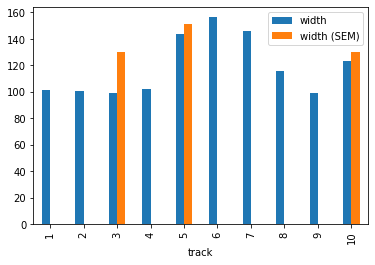

In [19]:
comb.plot(y=['width','width (SEM)'],kind='bar')

<AxesSubplot:xlabel='track'>

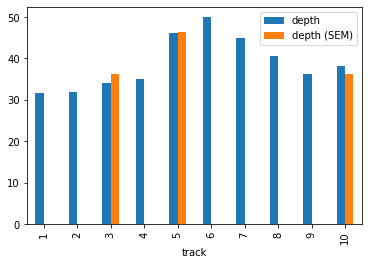

In [21]:
comb.plot(y=['depth','depth (SEM)'],kind='bar') 